# Lab 8 - Patch foraging

This lab has 4 main components designed to give provide an theoretical and experiental/interactive understanding of foraging in patchy environments.

Sections:
1. Consider foraging in "patchy" environments, and build a simulated patchy environment.
1. Predict and evaluate the behavior of agents with different exploration strategies in the patchy environment.
1. Predict and evaluate how agents' behavior & performance will change as characteristics of the patchy environment change.


## Background

### Real environments are "patchy".
- So far, we've been playing around with simulated environments where food ("targets") are spread uniformly over space.
- In reality, environments are often "patchy". For example, berries or flowers may be concentrated on isolated bushes, which are spaced apart from one another

### Patchy environments define the foraging problem.
- The problem of foraging requires that an organism navigate through an environment to find food, balancing the metabolic costs of movement with the energy provided by collected morsels.
- In an environment where targets are dispersed uniformly, foraging is rather simple - moving around from via some form of random walk, collecting targets, perhaps with behavior imformed by scent cues.
- A patchy environment complicates things - with no food in between patches, between-patch movement can become dangerous at long transit times. Patchy environments thus demand a foraging strategy that is sensitive to the sparsely-dense stucture of food availability.

### We can think of optimal foraging in terms of a simplified model.
- Charnov (1976) proposed a model of optimal foraging.
- Charnov's model formulates foraging space as divided into sections (patches) of different types, and the inter-patch space between them. See the illustration of this from his paper below (and consider how this simple model matches the real environment above so much better than uniformly distributed targets!).
![Charnov patch model illustration screenshot](https://raw.githubusercontent.com/CoAxLab/BiologicallyIntelligentExploration/main/Labs/Charnov_patches_screenshot.png)
- When we think about foraging in this way, it becomes clear that there is an important distinction between time spent *in* and *between* patches.
- Critically, off-patch time and on-patch time (for different patch types) determines energy intake rate for organisms.
- In Charnov's model, within-patch energy is depleted as a forager consumes the energy within that patch. Thus there is a point at which an optimal forager should leave a patch in aims of finding another. This is where the formulas in his marginal value come into play.

Next up, let's get set up to run some patch environment simulations!

## Section 0 - Setup

The setup is the same as prior labs.

Install our code libraries as usual

In [ ]:
!pip install --upgrade git+https://github.com/coaxlab/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

  Cloning https://github.com/coaxlab/explorationlib to /tmp/pip-req-build-11_hri3b
  Running command git clone --filter=blob:none --quiet https://github.com/coaxlab/explorationlib /tmp/pip-req-build-11_hri3b
  Resolved https://github.com/coaxlab/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42775 sha256=5cc1285e04bd5480f4a605584efdceb3b5363ec67864751cff7d43a6e8a5246e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ll431xgr/wheels/71/57/e8/88c93e85ce02efaef024038b2ddcb6c6dec8a1a212f712bb05
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-4so3egq1
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-4so3egq1
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a6213520612f44fb1bc49114
  Prep

Import specific modules from the libraries we loaded. We'll use these modules to create and plot enviornments, run experiments with different exploration agents in these environments, visualize their behaviors, and evaluate their performance according to various metrics.

In [ ]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientInfoGrid

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

/usr/local/lib/python3.10/dist-packages/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_re

## Section 1 - Building a simulated patchy environment

- Below is some environment setup code that should look pretty standard compared to the previous labs you've seen in this class.
- The key difference is the generation of targets using a new function, `uniform_patch_targets()` - in other labs we've only used `uniform_targets()`.
- This new function randomly places circular patches in the environment, and then places targets at random with uniform probability within each patch.
- To specify the characteristics of the patchy environment we want to generate, we supply information about how many patches we want (`n_patches`), how many targets we want per patch (`n_per_patch`), and how large we want each patch to be (`radius`).
- To be clear, our simulation won't be perfect - this function can create overlapping patches, and our simulations don't take into account the depletion of patches over time.

We will create a patch environmet with *7 patches* of *10 targets each*. Make each patch have a *radius of 2 units*.

In [ ]:
# Noise and missing scents
p_scent = 0.1
noise_sigma = 2

# Shared agent parameters
num_experiments = 50
num_steps = 500
seed_value = 52317

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 8 #         # number of patches
n_per_patch = 20 #      # number targets per patch
radius = 1 #            # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)
values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Visualizing this environment

Run the code below to visualize the patchy environment that you just built!

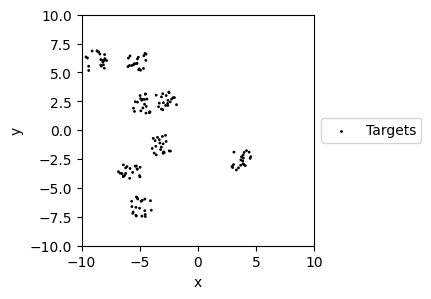

In [ ]:
plot_boundary = (10, 10)
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

## Section 2 - Different exploration strategies in the patchy environment

Now we will predict and evaluate the behavior of agents with different exploration strategies in the patcy environment. We will pick up on the three types of agents we have worked with so far.

- A random, Brownian random walker
- A simple chemotaxis agent
- A curious infotaxis agent

These are agents that we have used in pervious labs. See those labs to remember how these agents work.


In [ ]:
# Agents

# Random search agent
rand = DiffusionGrid(min_length=min_length)
rand.seed(seed_value)

# Common parameters
min_length = 1
p_neg = 0.8
p_pos = 0.2

# Chemotaxis agent
chemo = GradientDiffusionGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
)
chemo.seed(seed_value)


# Infotaxis agent
threshold=0.05
info = GradientInfoGrid(
    min_length=min_length,
    p_neg=p_neg,
    p_pos=p_pos,
    threshold=threshold,
)

info.seed(seed_value)

[52317]

**Note:** you may like to start the next experiments running as you answer these questions.

---
### Question 2.1

Which agent do you think will spend the most time in patches? Which agent do you think will spend the least time in patches? Why?

__Answer:__

The **chemotaxis** agent will spend the most time in patches because it follows gradient cues to high-reward areas, remaining there until resources deplete.

The **random** agent will spend the least time in patches due to its undirected movement, causing it to leave patches randomly without exploiting them efficiently.

---
### Question 2.2

Which agent do you think will accumulate the most reward (spend the most time next to targets?). Which do you think will spend the least? Why?

__Answer:__

The **chemotaxis agent** will accumalate the most reward because it is designed to follow resource gradients and remain in high-reward patches until the resources are depleted, maximizing the time spent near/ at targets.


The **random agent** will accumalate the least reward because it is undirected movement reduces its ability to locate and stay near targets, resulting in inefficient resource collection.

---
### Question 2.3

Which agent do you think will have the most deaths? Which do you think will have the least? Why?

__Answer:__

The **rando agent** will have the most deaths, because it undirected movement would increase the likelihood of the agent spending excessive time in low-resouce areas, leading to resource depletion and then death.

The **chemotaxis agent** will have the least deaths, because it is efficient at locating and and exploiting resource-rich patches, minimizing time spent in low-resources and reducing the risk of death.

Run the code below to perform a number of experiments, simulating how these different agents behave in the patch environment that you built.

In [ ]:
# Experiments
rand_exp = experiment(
    f"rand",
    rand,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)


rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

Run the code below to plot behavior of each agent type during one experiment example.

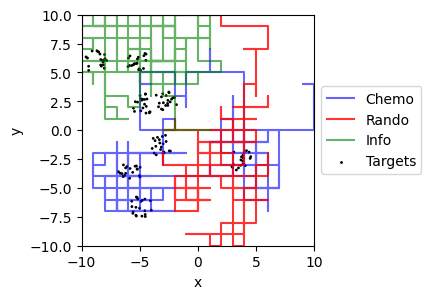

In [ ]:
plot_boundary = (10, 10)

# -
num_experiment = num_experiments - 1
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Question 2.4

Describe the behavior of each agent type in the experiment visualization above. Does the behavior match what you expected? Why do you think you see the specific pattern of behavior for each agent?

**Chemotaxis Agent**: Moves directly to resource patches and stays there, collecting as much as possible. This behavior matches what I expected because it follows gradients to find and stay in high-resource areas.

**Random Agent**: Moves randomly without clear direction, sometimes passing through patches but not staying long. This behavior matches what I expected since it doesn't have a strategy to find or stick to resources.

**Infotaxis Agent**: Moves between patches, spending some time in resource areas but not as long as the chemotaxis. This matches what I expected because it balances finding new resources and using known ones.

### Quantify time on-patches for each agent type

The code below makes use of a new scoring function, `on_off_patch_time()`. This function takes experiment results data and analyzes it to see how many time steps were spent on vs. off patches. Run the code block below to measure and plot the proportion of total time steps each agent spends on patches. See if the results match your predictions.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

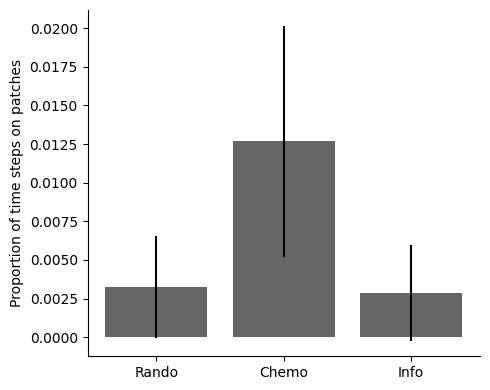

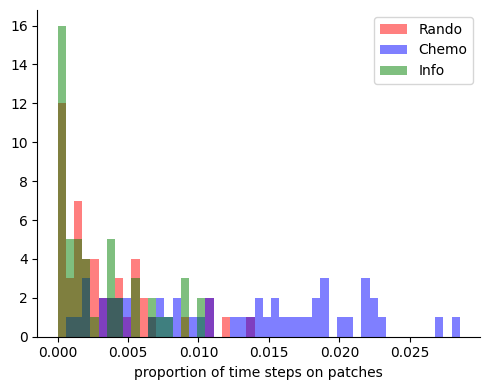

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo","Info"]
colors = ["red", "blue","green"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

### Quantify total reward for each agent type

Check if your predictions were correct.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

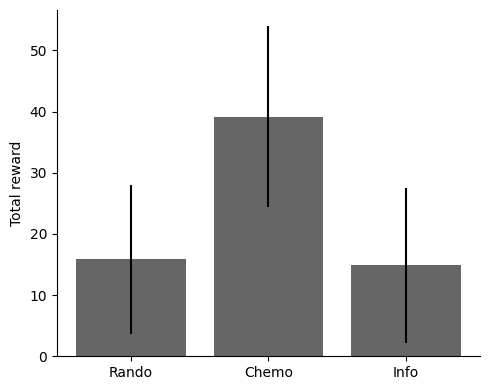

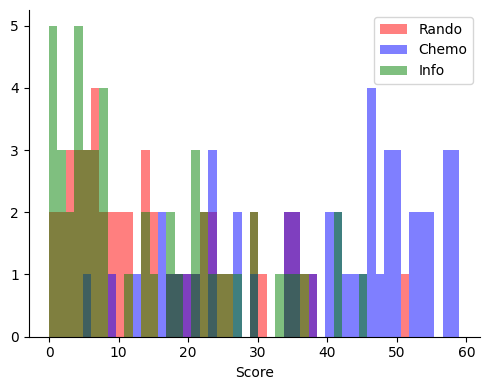

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo","Info"]
colors = ["red", "blue","green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Quantify deaths for each agent type

Check if your predictions were correct.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

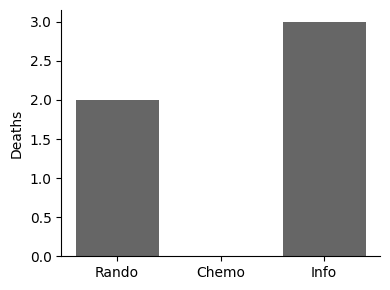

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

---
### Question 2.5

Were any of your predictions wrong? If so, what do you think caused the unexpected results?

__Answer:__

The infotaxis agent had the highest number of deaths (there is a 50% increase in the mortality rate of the info agent), contrary to my prediction that the random agent would have the most deaths. I think this occured because over time the info agent is going to start wander off, or even avoid certain patches, because it is exclusively curious and constantly seeking novelty. Essentially, the infotaxis agent may have spent too much time exploring instead of staying in resources patches.

---
### Question 2.6

Compare time on patch, total rewards, and deaths for the Chemo agent. What does this pattern tell you about the influence of a simple chemotaxis strategy for foraging?

__Answer:__

The chemotaxis agent spent the most times on patches, achieved the highest total rewards, and had the fewest deaths. The increased on time expended per patch correlates will the total number of rewards accumalated.

This pattern shows that a simple chemotaxis strategy is highly effective for foraging in environment with clear resource gradients. This emphasizes the need, or rather lack thereof, for complexity and optimality in effective foraging.

## Section 3 - Exploration strategies in different patchy environments

Let's look at a slightly harder foraging problem: sparse patches. We will create a new patch environment, just like our first one, but with only two patches of 20 targets each.

---
### Question 3.1

Which agent do you predict will do the best in terms of on-patch-proportion, total reward, and death.

__Answer:__

**The chemotaxis agent**

Here's how we'll set up the experiment

In [ ]:
# Noise and missing scents
p_scent = 0.1
noise_sigma = 2

# Shared agent parameters
num_experiments = 50
num_steps = 500
seed_value = 2074               # seed value for random number generator

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 2 #          # number of patches
n_per_patch = 20 #       # number targets per patch
radius = 3 #             # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

NameError: name 'np' is not defined

Now let's see our environment.

In [ ]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

NameError: name 'plot_targets2d' is not defined

Time to test our agents.

In [ ]:
# Experiments
rand_exp = experiment(
    f"rand",
    rand,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

First let's take a look at a good demonstration trial. I'm picking one example that will make sense in a little bit.

In [ ]:
plot_boundary = (10, 10)

# - Picking a good example that is consistent with summary results
num_experiment = 4
ax = None
ax = plot_position2d(
    select_exp(chemo_exp, num_experiment),
    boundary=plot_boundary,
    label="Chemo",
    color="blue",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label="Rando",
    color="red",
    alpha=0.8,
    ax=ax,
)
ax = plot_position2d(
    select_exp(info_exp, num_experiment),
    boundary=plot_boundary,
    label="Info",
    color="green",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

Okay, now let's take a look at time on patch.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

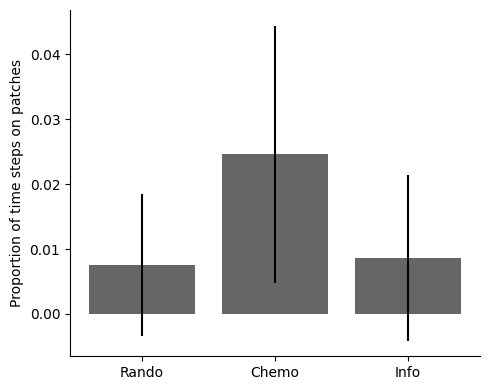

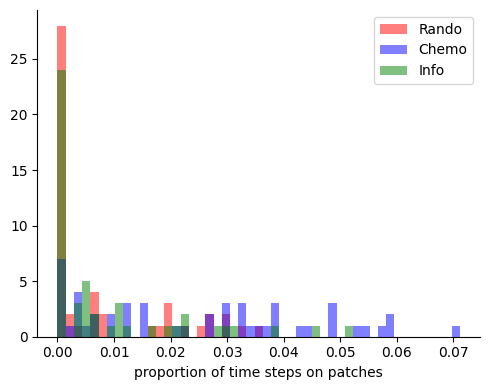

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

Interesting patterns that I have some questions about at the end.

Now, let's look at total rewards.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

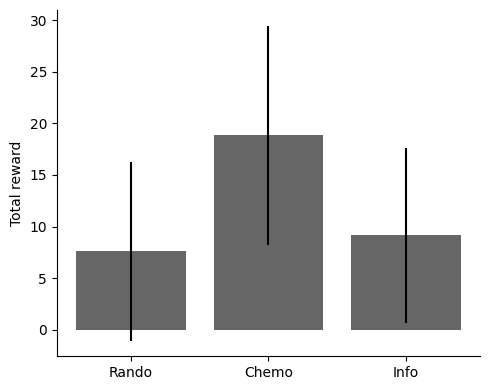

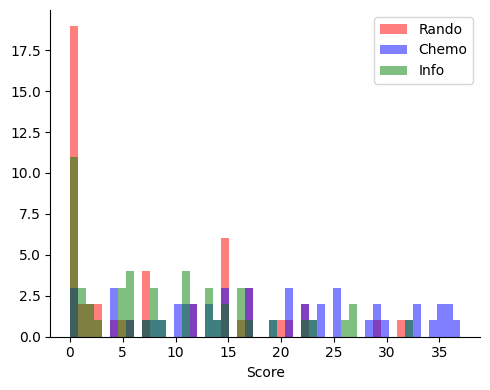

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

Interesting. Look at the difference between our chemotaxis agent and our curious (infotaxis) agent.

Now we can look at the contrastive performance measure of deaths.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

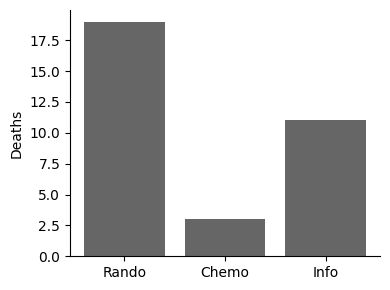

In [ ]:
# Results
results = [rand_exp, chemo_exp, info_exp]
names = ["Rando", "Chemo", "Info"]
colors = ["red", "blue", "green"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

---
### Question 3.2

Did the results match your predictions? If not, why do you think you saw the results that came up?

__Answer:__

Yes, as predicted, the chemo agent performed the best. However, initally the rando agent did have more deaths than the info agent in this sparse environment. I think that while the info agent balances exploration and exploitation, in sparse environments, its tendency to explore more could leas to increased times spent away from resource patches, which could cause higher energy depletion.

---
### Question 3.3

Re-run the above simulations in Section 3, but change the seed value for the random number generator. Do this four different times, once each with the following values: 2074, 3074, 4074, 5074.

What do you see in the performance of the agents with each new seed value (which specifies different unique environments)?

__Answer:__

*Said in class that we just have to do one seed value.I choose seed value = 2074*

For the rando agent, the performance remains poor (high deaths and low rewards) because it undirected movement does not neccesarily adapt to different environments.

For the chemotaxis agent, the performance remains strong (low deaths and high rewards) because it effectively follows gradients to exploit the resource patches.

For the infotaxis agent, the perforance improved with the new seed, because the new patch layout likely provides conditions (closer patches, better gradients) that reduce exploration time and enhance resource exploitation.


---
**IMPORTANT** Did you collaborate with anyone on this assignment, or use LLMs like ChatGPT? If so, list their names here.
> *Write Name(s) here*